# Airline Sentiment
We attempt to train a classification model to predict the sentiment of tweets that are related to airlines. Tweets are either neutral, positive or negative.
https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
import fastai
print(fastai.__version__)


1.0.51


In [8]:
from fastai.text import *

### Load in the data

In [9]:
from pathlib import Path
path = Path('./')

In [10]:
df = pd.read_csv(path/'Tweets.csv')

In [11]:
df.shape

(14640, 15)

In [7]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [12]:
col_names=['label','text']

In [13]:
df_new = pd.DataFrame({'label':df['airline_sentiment'], 'text':df['text']},columns=col_names)

In [14]:
df_new.head()

,label,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [12]:
df_new.to_csv(path/'train.csv', header=col_names, index=False)

In [13]:
p = pd.read_csv('train.csv')

### Datablock API

In [20]:
bs=48

In [22]:
data_lm = (TextList.from_csv(path, csv_name='train.csv', cols='text')
            .random_split_by_pct(0.1)
           #10% of the data becomes our validation set
            .label_for_lm()           
            .databunch(bs=bs))

In [23]:
data_lm.save()

In [24]:
data_lm = load_data(path)

In [25]:
data_lm.show_batch()

idx,text
0,"this playing . \n it 's really the only bad thing about flying xxup va xxbos @virginamerica yes , nearly every time i fly xxup vx this “ xxunk xxunk ” wo n’t go away :) xxbos @virginamerica xxmaj well , i xxunk … but xxup now i xxup do ! xxup xxunk xxbos @virginamerica it was amazing , and arrived an hour early . xxmaj you 're too"
1,"! ! ! 💗 xxbos @virginamerica sounds like fun ! xxbos @virginamerica any updates on flight 413 from xxmaj jfk > xxmaj lax xxbos @virginamerica xxunk xxunk ! xxbos @virginamerica the xxup xxunk on your site is a 404 right now , please fix . xxmaj site unusable . xxbos @virginamerica xxmaj we 're on flight xxunk xxmaj vegas to xxmaj boston today , checked in online but our bag"
2,in xxmaj elevate ? xxbos @virginamerica morning . xxmaj if i have a question regarding elevate points & & flights can i xxup dm you ? xxbos @virginamerica still waiting to see xxunk _ 😞 xxbos @virginamerica was wondering if you guys recieved my dm and we 're able to xxunk respond asap xxbos @virginamerica xxmaj flying xxup lax to xxup sfo and after looking at the awesome movie xxunk
3,".. xxbos @united xxunk worse customer service ever . xxmaj problems will happen , how you deal xxunk a company . xxmaj never again xxmaj united . xxbos @united xxmaj thanks for the lack of help and the canned response from the 1 k desk ! xxbos @united xxmaj it 's too bad xxup ua has had another xxunk operational issue on my return flight . xxbos @united i would"
4,xxmaj staff rude . xxmaj expensive luggage xxunk around etc . xxbos @united has the xxup worst customer xxunk ! xxmaj this xxmaj xxunk rep at call center must be investigated . xxmaj my baggage 's lost and there 's no help but argument ! xxbos @united should xxup not sell tickets for @silverairways on http : / / t.co / xxunk has terrible service and xxup ua staff can


### Language Model
We do not train the classication model straight away, we first finetune a pretrained LM on our corpus.

In [26]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [18]:
data_lm.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
"xxbos @united xxup xxunk from xxup ric , xxup ua507 from xxup ord , & & xxup xxunk from xxup den xxup xxunk xxup delayed for non - weather issues . xxmaj way to go , you re batting 1.000 ! xxmaj but no hotels",negative
xxbos @usairways i wish we were on our way . xxmaj now there 's a problem w / de - icing . xxmaj three & & 1 / 2 hour delay so far & & xxunk not sure if we 'll be taking off .,negative
xxbos @usairways i do n't think the xxup us site allows that ( unlike http : / / t.co / etfjqiwuvt ) . xxmaj can i use a xxup us credit if i held on http : / / t.co / etfjqiwuvt ?,neutral
xxbos @jetblue 5hrs on xxmaj tarmac yest b4 xxmaj cancelled xxmaj flight xxunk . xxmaj today 3 + hr delay . xxmaj why not send txt / email re : xxup jfk closed & & saved all trip 2 sit xxunk again ?,negative


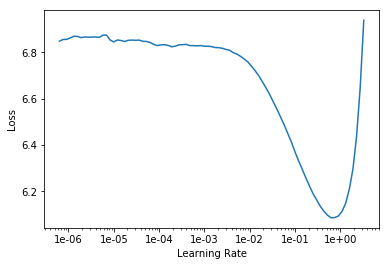

In [31]:
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.631202,4.046782,0.245996,00:14


In [33]:
learn.save('fit_head')

In [34]:
learn.load('fit_head');

In [35]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.991107,3.846243,0.272078,00:19
1,3.822566,3.714374,0.286580,00:19
2,3.635360,3.650841,0.293182,00:20
3,3.481527,3.627111,0.296618,00:20
4,3.385444,3.629344,0.296916,00:20


In [36]:
learn.save('fine_tuned')

In [27]:
learn.load('fine_tuned');

We can see our language model at work here. Although it isn't super great, it will serve as a good foundation for our classification model.

In [30]:
TEXT = "We had a great time"
N_WORDS = 30
N_SENTENCES = 5

In [31]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

We had a great time , but cancelled we need to get 1 the flights for a snacks . Area so aa send on the crew connection . xxbos @united Http we get
We had a great time . That relative @americanair have . Dfw , you can vx . Thanks ! xxbos @jetblue you 3 can first paid in a first way to get
We had a great time and we ever from something thanks xxbos has i all a boarding a Gon Quick with an Fee Into they just calling . My @virginamerica
We had a great time . We can message a once xxbos @united flightled getting my united . We : not help appreciate to get have OTHER Someone agents . xxbos
We had a great time , Ppl david to hours on HOURS Company . We ever from no our telling for our professional . We phx having weather . xxbos


We save the encoder for use in the classification model.

In [105]:
learn.save_encoder('fine_tuned_enc')

### Classification model

In [58]:
data_clas = TextClasDataBunch.from_csv(Path(path), 'train.csv', text_cols=1, label_cols=0,vocab=data_lm.vocab)


In [112]:
data_clas.save('data_clas.pkl')

In [80]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [114]:
data_clas.show_batch()

text,target
xxbos @united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup xxunk xxup over xxup the xxup xxunk xxup on xxup flight xxunk xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
xxbos @southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj xxunk xxmaj like u xxmaj in xxmaj future !,positive
"xxbos @southwestair $ xxunk xxunk 4 / 30 - 5 / 5 "" xxup xxunk : xxup rt xxunk : xxmaj if you 're trying to make travel reservations for xxmaj vegas on xxmaj may 2nd it 's too xxmaj late xxmaj flight """,neutral
xxbos @united xxmaj from the air : xxmaj another missed xxunk 2day . xxup atc went on strike in xxmaj belize this xxup am . xxmaj now family & & i miss xxunk in xxup ewr . xxmaj please see my dms .,negative
"xxbos @southwestair "" xxmaj will my luggage be on that flight ? "" "" xxmaj no "" "" y not "" "" bc ur on that flight n it wo n't end up where ur goin http : / / t.co / xxunk",negative


In [81]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [116]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


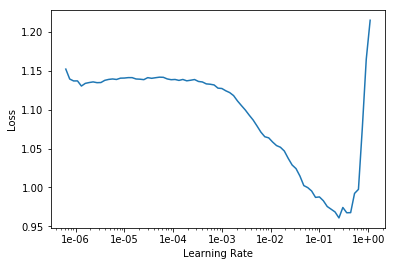

In [117]:
learn.recorder.plot()

In [118]:
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.715743,0.573033,0.752134,00:11


In [119]:
learn.save('first')

In [120]:
learn.load('first');

In [121]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(2e-2/(2.6**4),2e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.657033,0.518989,0.786958,00:13


In [122]:
learn.save('second')

In [123]:
learn.load('second');

In [124]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.569410,0.483337,0.810857,00:20


In [125]:
learn.save('third')

In [82]:
learn.load('third');

In [129]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.558320,0.477615,0.819051,00:25
2,0.528352,0.452912,0.824172,00:26
3,0.468203,0.437663,0.830659,00:26
4,0.416983,0.442519,0.834756,00:26
5,0.404567,0.448368,0.834414,00:26


In [94]:
preds = learn.predict("Why did it have to rain today?")
preds[0]

Category negative

In [97]:
preds = learn.predict("It was a pretty awesome flight overall, definitely would fly Airasia again.")
preds[0]

Category positive

In [99]:
preds = learn.predict("My name is James.")
preds[0]

Category neutral

In [101]:
preds = learn.predict("We are flying with Delta airlines today.")
preds[0]

Category neutral

In [84]:
# # if learn.predict throws an error run this cell
# learn.data.processor[0].include_bos = True
# learn.data.processor[0].include_eos = False
# learn.data.processor[0].mark_fields = False

Overall, we can see that sentiment prediction is pretty reasonable overall.